K-Means算法的具体应用
===
K-Means的具体应用有三个：图像识别，减色处理与图像压缩

# 1.图像识别
不需要预期输出的无监督学习

## 1.1.生成质心
- 对图像进行减色化处理，然后计算直方图，将其用作特征量；
- 对每张图像随机分配类别0或类别1
- 分别计算类别0和类别1的特征量的质心并存储

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# Dicrease color
def dic_color(img):
    img //= 63
    img = img * 64 + 32
    return img


# Database
def get_DB():
    # get training image path
    train = glob("data/dataset/test_*")
    train.sort()

    # prepare database
    db = np.zeros((len(train), 13), dtype=np.int32)
    pdb = []

    # each train
    for i, path in enumerate(train):
        # read image
        img = dic_color(cv2.imread(path))
        # histogram
        for j in range(4):
            db[i, j] = len(np.where(img[..., 0] == (64 * j + 32))[0])
            db[i, j+4] = len(np.where(img[..., 1] == (64 * j + 32))[0])
            db[i, j+8] = len(np.where(img[..., 2] == (64 * j + 32))[0])

        # get class
        if 'akahara' in path:
            cls = 0
        elif 'madara' in path:
            cls = 1

        # store class label
        db[i, -1] = cls

        # add image path
        pdb.append(path)

    return db, pdb

# k-Means step1
def k_means_step1(db, pdb, Class=2):
    # copy database
    feats = db.copy()

    # initiate random seed
    np.random.seed(1)

    # assign random class 
    for i in range(len(feats)):
        if np.random.random() < 0.5:
            feats[i, -1] = 0
        else:
            feats[i, -1] = 1

    # prepare gravity
    gs = np.zeros((Class, 12), dtype=np.float32)
        
    # get gravity
    for i in range(Class):
        gs[i] = np.mean(feats[np.where(feats[..., -1] == i)[0], :12], axis=0)
    print("assigned label")
    print(feats)
    print("Grabity")
    print(gs)


db, pdb = get_DB()
k_means_step1(db, pdb)

assigned label
[[ 1493  7892  4900  2099  1828  9127  4534   895  1554  6750  5406  2674
      0]
 [  242 10338  3628  2176   587 12212  2247  1338   434 10822  4506   622
      1]
 [ 6421  5478   719  3766  5482  4294  2537  4071  5609  4823  2051  3901
      0]
 [ 3343  8134  4756   151  3787  7588  3935  1074  3595  8444  4069   276
      0]]
Grabity
[[ 3752.3333  7168.      3458.3333  2005.3334  3699.      7003.
   3668.6667  2013.3334  3586.      6672.3335  3842.      2283.6667]
 [  242.     10338.      3628.      2176.       587.     12212.
   2247.      1338.       434.     10822.      4506.       622.    ]]


## 1.2.聚类
- 对于每个图像，计算特征量与质心之间的距离(在此取欧氏距离)，并将图像指定为质心更接近的类别。
- 重复步骤直到没有数据的类别再改变为止。

k-平均聚类算法是一种完全按范围划分类别的方法。一条数据最后被划分到什么类别只有到最后才清楚。此外，必须预先知道类别的数量。需要注意的是，k-平均聚类算法最初分配的类别对最后的结果有很大的影响。并且，数据量小的情况下极有可能失败。也就是说，数据量越大最后得到的数据分布越准确。

In [2]:
def get_DB():
    # get training image path
    train = glob("data/dataset/train_*")
    train.sort()

    # prepare database
    db = np.zeros((len(train), 13), dtype=np.int32)
    pdb = []

    # each train
    for i, path in enumerate(train):
        # read image
        img = dic_color(cv2.imread(path))
        # histogram
        for j in range(4):
            db[i, j] = len(np.where(img[..., 0] == (64 * j + 32))[0])
            db[i, j+4] = len(np.where(img[..., 1] == (64 * j + 32))[0])
            db[i, j+8] = len(np.where(img[..., 2] == (64 * j + 32))[0])

        # get class
        if 'akahara' in path:
            cls = 0
        elif 'madara' in path:
            cls = 1

        # store class label
        db[i, -1] = cls

        # add image path
        pdb.append(path)

    return db, pdb

def k_means_step2(db, pdb, Class=2):
    # copy database
    feats = db.copy()

    # initiate random seed
    np.random.seed(1)

    # assign random class 
    for i in range(len(feats)):
        if np.random.random() < 0.5:
            feats[i, -1] = 0
        else:
            feats[i, -1] = 1

    while True:
        # prepare greavity
        gs = np.zeros((Class, 12), dtype=np.float32)
        change_count = 0

        # compute gravity
        for i in range(Class):
            gs[i] = np.mean(feats[np.where(feats[..., -1] == i)[0], :12], axis=0)

        # re-labeling
        for i in range(len(feats)):
            # get distance each nearest graviry
            dis = np.sqrt(np.sum(np.square(np.abs(gs - feats[i, :12])), axis=1))

            # get new label
            pred = np.argmin(dis, axis=0)

            # if label is difference from old label
            if int(feats[i, -1]) != pred:
                change_count += 1
                feats[i, -1] = pred

        if change_count < 1:
            break

    for i in range(db.shape[0]):
        print(pdb[i], " Pred:", feats[i, -1])
        
db, pdb = get_DB()
k_means_step2(db, pdb)

data/dataset/train_akahara_1.jpg  Pred: 0
data/dataset/train_akahara_2.jpg  Pred: 0
data/dataset/train_akahara_3.jpg  Pred: 0
data/dataset/train_akahara_4.jpg  Pred: 0
data/dataset/train_akahara_5.jpg  Pred: 0
data/dataset/train_madara_1.jpg  Pred: 0
data/dataset/train_madara_2.jpg  Pred: 1
data/dataset/train_madara_3.jpg  Pred: 1
data/dataset/train_madara_4.jpg  Pred: 1
data/dataset/train_madara_5.jpg  Pred: 1


## 1.3.调整初期类别

In [3]:
# k-Means
def k_means(db, pdb, Class=2, th=0.5):
    # copy database
    feats = db.copy()

    # initiate random seed
    np.random.seed(4)

    # assign random class 
    for i in range(len(feats)):
        if np.random.random() < th:
            feats[i, -1] = 0
        else:
            feats[i, -1] = 1

    while True:
        # prepare greavity
        gs = np.zeros((Class, 12), dtype=np.float32)
        change_count = 0

        # compute gravity
        for i in range(Class):
            gs[i] = np.mean(feats[np.where(feats[..., -1] == i)[0], :12], axis=0)

        # re-labeling
        for i in range(len(feats)):
            # get distance each nearest graviry
            dis = np.sqrt(np.sum(np.square(np.abs(gs - feats[i, :12])), axis=1))

            # get new label
            pred = np.argmin(dis, axis=0)

            # if label is difference from old label
            if int(feats[i, -1]) != pred:
                change_count += 1
                feats[i, -1] = pred

        if change_count < 1:
            break

    for i in range(db.shape[0]):
        print(pdb[i], " Pred:", feats[i, -1])

k_means(db, pdb, th=0.3)

data/dataset/train_akahara_1.jpg  Pred: 1
data/dataset/train_akahara_2.jpg  Pred: 1
data/dataset/train_akahara_3.jpg  Pred: 1
data/dataset/train_akahara_4.jpg  Pred: 1
data/dataset/train_akahara_5.jpg  Pred: 1
data/dataset/train_madara_1.jpg  Pred: 0
data/dataset/train_madara_2.jpg  Pred: 0
data/dataset/train_madara_3.jpg  Pred: 0
data/dataset/train_madara_4.jpg  Pred: 0
data/dataset/train_madara_5.jpg  Pred: 0


# 2.减色处理
使用K平均聚类算法动态确定要减少的颜色

## 2.1.按颜色距离分类
- 从图像中随机选取$K$个$RGB$分量(这我们称作类别)
- 将图像中的像素分别分到颜色距离最短的那个类别的索引中去，色彩距离按照下面的方法计算：
$$\text{dis}=\sqrt{(R-R')^2+(G-G')^2+(B-B')^2}$$

## 2.2.减色处理
- 计算各个索引下像素的颜色的平均值，这个平均值成为新的类别；
- 如果原来的类别和新的类别完全一样的话，算法结束。如果不一样的话，重复步骤2和步骤3；
- 将原图像的各个像素分配到色彩距离最小的那个类别中去。

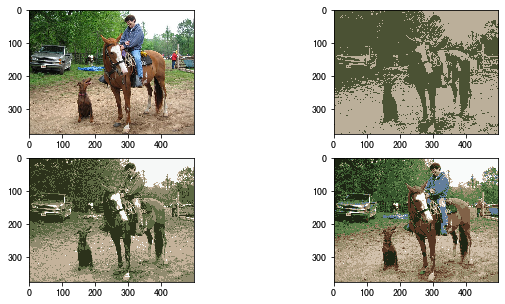

In [4]:
from PIL import Image
import numpy as np
import time
import matplotlib.pyplot as plt
# from dask_ml.cluster import KMeans
from sklearn.cluster import KMeans
def vector_of_pixels(np_im):
    pixels = []
    for row in np_im:
        for pixel in row:
            pixels.append(pixel)
    return np.asarray(pixels)

def pixels_from_path(file_path):
    im = Image.open(file_path)
    np_im = np.array(im)
    return np_im

def clustered_pixels(x_fit, pixels):
    labels = x_fit.predict(pixels)
    res= x_fit.cluster_centers_[labels] 
    return res

def reshape_pixels(pixels, width, height):
    resulting_pixels = [[] for _ in range(height)]
    for i in range(height):
        for j in range(width):
            resulting_pixels[i].append(pixels[width*i+j])
    return np.asarray(resulting_pixels)

def compress_image(np_im, k):
    
    x,y = np_im.shape[0],np_im.shape[1]
    pixels = vector_of_pixels(np_im)
    
    km = KMeans(n_clusters=k, init='k-means++')
    x_fit = km.fit(pixels)

    clust_pixels = clustered_pixels(x_fit, pixels)

    x_floor = reshape_pixels(clust_pixels, y, x)
    return x_floor

file_path = "Images/01/09/02.jpg"
np_im = pixels_from_path(file_path)

plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(2, 2, 1) 
plt.imshow(np_im)

plt.subplot(2, 2, 2)
k2Image = compress_image(np_im, 2)
plt.imshow(k2Image / 255)

plt.subplot(2, 2, 3)
k5Image = compress_image(np_im, 5)
plt.imshow(k5Image / 255)

plt.subplot(2, 2, 4)
k10Image = compress_image(np_im, 10)
plt.imshow(k10Image / 255)

# 3.三通道图片的压缩
k-means算法实现把一个彩色图压缩成了灰度图，此时的灰度图不再使用三个通道，而使用单通道图，这样就可以节省彩色图片的存储空间

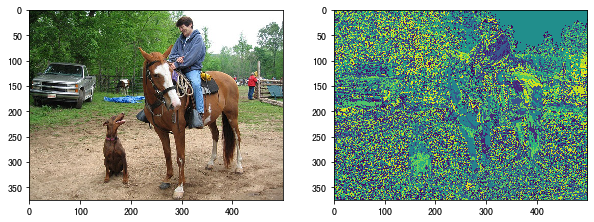

In [5]:
# -*- coding:utf-8 -*-
from skimage import io
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

image = io.imread("Images/01/09/02.jpg")

plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(1, 2, 1) 
plt.imshow(image)

rows = image.shape[0]
cols = image.shape[1]
image = image.reshape(image.shape[0]*image.shape[1],3)
kmeans = KMeans(n_clusters=128, n_init=10, max_iter=200)
kmeans.fit(image)
clusters = np.asarray(kmeans.cluster_centers_, dtype=np.uint8)
labels = np.asarray(kmeans.labels_, dtype=np.uint8)
labels = labels.reshape(rows, cols);

plt.subplot(1, 2, 2)
plt.imshow(labels / 255)